In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pydeseq2

In [2]:
transcriptome = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/General_data/plate1_4_tpm_normalized.csv",
    index_col=0,
)
rows_to_drop_expression_data = [
    "A2450525897_n01_undetermined",
    "A2449446903_n01_undetermined",
    "B250508004_n01_undetermined",
    "B2449500127_n01_undetermined",
]
transcriptome = transcriptome.drop(index=rows_to_drop_expression_data)
transcriptome = transcriptome.sort_index()

metadata = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/General_data/Plates_1_to_4_metadata_merged_luke.csv",
    index_col=0,
)
metadata = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/General_data/Plates_1_to_4_metadata_merged_luke.csv",
    index_col=0,
)
metadata = metadata.drop(
    columns=[
        "arb.sort",
        "sample-id",
        "Ambiguous Unstranded",
        "Ambiguous Forward",
        "Multimapping",
        "Unmapped Over Mapped",
    ]
)
metadata["Date and Time"] = metadata["date"] + " " + metadata["time"]
luke_time_data_format = "%-m/%-d/%y %-H:%-M"
metadata["Date and Time"] = pd.to_datetime(
    metadata["Date and Time"], format=luke_time_data_format
)

unusable_samples = [
    "A2450525897_n01_LICRNA01_A06",
    "A2450525897_n01_LICRNA01_A08",
    "A2450525897_n01_LICRNA01_C11",
    "A2450525897_n01_LICRNA01_D11",
    "A2450525897_n01_LICRNA01_D12",
    "A2449446903_n01_LICRNA02_F01",
    "B2449500127_n01_LICRNA04_A04",
    "B2449500127_n01_LICRNA04_A06",
    "B2449500127_n01_LICRNA04_A07",
]
borderline_unusable = [
    "A2450525897_n01_LICRNA01_F03",
    "A2450525897_n01_LICRNA01_G07",
    "A2449446903_n01_LICRNA02_A04",
    "A2449446903_n01_LICRNA02_H10",
    "B2449500127_n01_LICRNA04_H02",
    "B2449500127_n01_LICRNA04_H11",
]
all_unsable = borderline_unusable + unusable_samples

trimmed_transcriptome = transcriptome.drop(index=all_unsable)
trimmed_metadata = metadata.drop(index=all_unsable)
trimmed_metadata = trimmed_metadata.sort_index()
trimmed_transcriptome = trimmed_transcriptome.dropna(how="all", axis=0)
trimmed_transcriptome = trimmed_transcriptome.dropna(how="all", axis=1)

In [3]:
microbiome_abundance = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/Microbiome/lic2024_16S_rab.csv"
)
long_term_microbiome = microbiome_abundance.merge(
    metadata[["sampID", "Experiment Type"]], left_on="plantID", right_on="sampID"
)
long_term_microbiome

,Sample,sample.type,timepoint,date,time,platename,daysincestart,plantID,Kingdom,Phylum,Class,Order,Family,Genus,Species,AbundR100,sampID,Experiment Type
0,LIC522,plant,c1_t11,2/11/24,12:00,LICCIRC_02,102,LIC522,d__Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales_A_650611,Pseudomonadaceae,Pseudomonas_E_647464,Pseudomonas_E_647464 viridiflava,79.1,LIC522,Circadian Experiment 1
1,LIC063,plant,t06,11/28/23,8:00,LIC_01,27,LIC063,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae_486827,Sphingomonas_L_486704,Sphingomonas_L_486704 sp000786205,66.1,LIC063,Long Term
2,LIC159,plant,t14,1/23/24,8:00,LIC_02,83,LIC159,d__Bacteria,Cyanobacteriota,Cyanobacteriia,Cyanobacteriales,Coleofasciculaceae,Caldora,Caldora sp010672925,60.5,LIC159,Long Term
3,LIC452,plant,c1_t06,2/10/24,16:00,LICCIRC_01,101,LIC452,d__Bacteria,Pseudomonadota,Gammaproteobacteria,Burkholderiales,Burkholderiaceae_A_595421,Massilia_574544,Massilia atriviolacea,59.8,LIC452,Circadian Experiment 1
4,LIC306,plant,t26,3/8/24,8:00,LIC_04,128,LIC306,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae_486827,Sphingomonas_L_486704,Sphingomonas_L_486704 sp000786205,57.2,LIC306,Long Term
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12281,LIC122,plant,t11,12/15/23,8:00,LIC_02,44,LIC122,d__Bacteria,Actinomycetota,Actinomycetes,Propionibacteriales,Nocardioidaceae,Nocardioides_A_392796,Nocardioides_A_392796 hankookensis,0.5,LIC122,Long Term
12282,LIC028,plant,t03,11/14/23,8:00,LIC_01,13,LIC028,d__Bacteria,Actinomycetota,Actinomycetes,Mycobacteriales,Geodermatophilaceae,Modestobacter,Modestobacter muralis,0.5,LIC028,Long Term
12283,LIC631,plant,c2_t05,3/2/24,12:00,LICCIRC_03,122,LIC631,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Brevundimonas,Brevundimonas subvibrioides,0.5,LIC631,Circadian Experiment 2
12284,LIC629,plant,c2_t05,3/2/24,12:00,LICCIRC_03,122,LIC629,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Rhizobiales_505101,Rhizobiaceae,Agrobacterium,Agrobacterium larrymoorei,0.5,LIC629,Circadian Experiment 2


In [4]:
trimmed_transcriptome

,AT1G01010,AT1G01020,AT1G03987,AT1G01030,AT1G01040,AT1G03993,AT1G01046,AT1G01050,AT1G03997,AT1G01060,...,ArthCt124,ArthCr088,ArthCt112,ArthCp088,ArthCp086,ArthCt118,ArthCp083,ArthCt111,ArthCp084,ArthCp085
A2449446903_n01_LICRNA02_A01,0.382839,11.929183,0.0,3.731527,3.602189,0.0,0.0,31.063543,0.0,3.966935,...,17.950907,44.209074,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,6.266498
A2449446903_n01_LICRNA02_A02,0.000000,5.826682,0.0,1.501594,3.439569,0.0,0.0,22.712417,0.0,18.186693,...,1.986484,9.688606,0.0,5.501032,0.0,0.0,0.519342,0.0,0.000000,3.467317
A2449446903_n01_LICRNA02_A03,1.021565,7.683520,0.0,0.301733,2.700528,0.0,0.0,42.431625,0.0,12.937632,...,7.983340,16.384320,0.0,7.983340,0.0,0.0,0.166972,0.0,0.000000,0.000000
A2449446903_n01_LICRNA02_A05,0.732717,3.149144,0.0,1.947758,3.742586,0.0,0.0,26.541337,0.0,23.861601,...,17.178143,17.005325,0.0,0.000000,0.0,0.0,0.628742,0.0,0.000000,0.000000
A2449446903_n01_LICRNA02_A06,1.614233,1.238895,0.0,6.130092,4.215597,0.0,0.0,19.379509,0.0,5.006570,...,16.219201,43.599301,0.0,0.000000,0.0,0.0,1.074213,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_H08,0.074367,4.474710,0.0,1.383813,2.059206,0.0,0.0,27.907884,0.0,11.118408,...,3.486989,4.209645,0.0,1.072920,0.0,0.0,0.948096,0.0,0.000000,0.760798
B250508004_n01_LICRNA03_H09,2.232353,6.249002,0.0,1.873955,3.869254,0.0,0.0,40.686812,0.0,7.391606,...,9.640892,4.655562,0.0,5.085306,0.0,0.0,0.360071,0.0,1.758217,4.807925
B250508004_n01_LICRNA03_H10,0.000000,0.000000,0.0,0.000000,2.953706,0.0,0.0,36.084398,0.0,0.000000,...,0.000000,4.975538,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
B250508004_n01_LICRNA03_H11,0.678594,7.655887,0.0,0.901942,4.195848,0.0,0.0,54.077818,0.0,0.334834,...,0.000000,2.304762,0.0,0.000000,0.0,0.0,0.166371,0.0,0.000000,0.694222


In [5]:
trimmed_metadata

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,plate_row,plate_col,Total Reads,Experiment Type,Sample Month,daysincestart,Date and Time
filename,,,,,,,,,,,,,,,,,
A2449446903_n01_LICRNA02_A01,A01,LIC157,plant,t14,1/23/24,8:00,LIC_02,LICRNA_02,758284.0,82176.0,A,1,1246970.0,Long Term,January,83,2024-01-23 08:00:00
A2449446903_n01_LICRNA02_A02,A02,LIC169,plant,t15,1/27/24,8:00,LIC_02,LICRNA_02,3071877.0,353549.0,A,2,4985602.0,Long Term,January,87,2024-01-27 08:00:00
A2449446903_n01_LICRNA02_A03,A03,LIC193,plant,t17,2/2/24,8:00,LIC_03,LICRNA_02,1213638.0,158864.0,A,3,2465662.0,Long Term,February,93,2024-02-02 08:00:00
A2449446903_n01_LICRNA02_A05,A05,LIC217,plant,t19,2/9/24,8:00,LIC_03,LICRNA_02,1303436.0,90929.0,A,5,1515395.0,Long Term,February,100,2024-02-09 08:00:00
A2449446903_n01_LICRNA02_A06,A06,LIC229,plant,t20,2/16/24,8:00,LIC_03,LICRNA_02,1591231.0,141665.0,A,6,1924391.0,Long Term,February,107,2024-02-16 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_H08,H08,LIC428,plant,c1_t04,2/10/24,8:00,LICCIRC_01,LICRNA_03,2552177.0,438552.0,H,8,5245242.0,Circadian Experiment 1,February,101,2024-02-10 08:00:00
B250508004_n01_LICRNA03_H09,H09,LIC440,plant,c1_t05,2/10/24,12:00,LICCIRC_01,LICRNA_03,4228242.0,493699.0,H,9,7715482.0,Circadian Experiment 1,February,101,2024-02-10 12:00:00
B250508004_n01_LICRNA03_H10,H10,LIC452,plant,c1_t06,2/10/24,16:00,LICCIRC_01,LICRNA_03,365095.0,39090.0,H,10,643786.0,Circadian Experiment 1,February,101,2024-02-10 16:00:00


In [8]:
species_abundance_table = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/General_data/Generated_data/species_core_results.csv"
)
species_abundance_table

,Species,n_samples_present,mean_abundance_present,median_abundance_present,prevalence,core
0,Kordiimonas sp002401685,372,3.661053,3.30,1.000000,True
1,Sphingomonas_L_486704 sp000786205,372,17.954211,15.90,1.000000,True
2,Rhodoferax_C aquaticus,370,4.407143,3.70,0.994624,True
3,Neorhizobium soli,366,3.855080,2.25,0.983871,True
4,Klenkia sp001424455,363,3.581402,2.70,0.975806,True
...,...,...,...,...,...,...
274,Tardiphaga robiniae,1,0.500000,0.50,0.002688,False
275,Telluria timonae,1,10.800000,10.80,0.002688,False
276,UBA4416 sp002420145,1,0.700000,0.70,0.002688,False
277,Umezawaea tangerina,1,1.100000,1.10,0.002688,False


In [9]:
### Note 372 total samples

In [10]:
species_abundance_table["rare"] = False
species_abundance_table.loc[
    species_abundance_table["n_samples_present"] <= 37, "rare"
] = True
species_abundance_table

,Species,n_samples_present,mean_abundance_present,median_abundance_present,prevalence,core,rare
0,Kordiimonas sp002401685,372,3.661053,3.30,1.000000,True,False
1,Sphingomonas_L_486704 sp000786205,372,17.954211,15.90,1.000000,True,False
2,Rhodoferax_C aquaticus,370,4.407143,3.70,0.994624,True,False
3,Neorhizobium soli,366,3.855080,2.25,0.983871,True,False
4,Klenkia sp001424455,363,3.581402,2.70,0.975806,True,False
...,...,...,...,...,...,...,...
274,Tardiphaga robiniae,1,0.500000,0.50,0.002688,False,True
275,Telluria timonae,1,10.800000,10.80,0.002688,False,True
276,UBA4416 sp002420145,1,0.700000,0.70,0.002688,False,True
277,Umezawaea tangerina,1,1.100000,1.10,0.002688,False,True


In [11]:
list_of_rare_species = species_abundance_table.loc[
    species_abundance_table["rare"] == True, "Species"
].tolist()
list_of_core_species = species_abundance_table.loc[
    species_abundance_table["core"] == True, "Species"
].tolist()
list_of_rare_species

['Bradyrhizobium sp000938255',
 'Noviherbaspirillum_A_568104 psychrotolerans',
 'Brevundimonas huaxiensis',
 'Mycobacterium paragordonae',
 'Aeromicrobium sp001426485',
 'Marmoricola_A_392027 sp001424755',
 'Flavobacterium sangjuense',
 'Herbaspirillum robiniae',
 'Hylemonella sp001432305',
 'Telluria mixta',
 'Undibacterium arcticum',
 'Brevundimonas sp001424025',
 'Herminiimonas arsenicoxydans',
 'Amnibacterium kyonggiense',
 'Patulibacter minatonensis',
 'Aquabacterium_A_592457 parvum',
 'Chioneia frigida',
 'Curtobacterium sp001422205',
 'Kineosporia rhamnosa',
 'Pseudonocardia hierapolitana',
 'Nakamurella panacisegetis',
 'Curvibacter gracilis',
 'Agrobacterium rubi',
 'Nocardioides_A_392796 ginsengisegetis',
 'Pseudoduganella namucuonensis',
 'Pseudomonas_E_647464 rhizosphaerae',
 'Actinoplanes rectilineatus',
 'Microbacterium_A_383321 testaceum_F',
 'Actinoplanes globisporus',
 'Herbaspirillum seropedicae',
 'Methylophilus methylotrophus',
 'Pseudomonas_E_647626 sp900573885',
 

In [12]:
list_of_core_species

['Kordiimonas sp002401685',
 'Sphingomonas_L_486704 sp000786205',
 'Rhodoferax_C aquaticus',
 'Neorhizobium soli',
 'Klenkia sp001424455',
 'Massilia atriviolacea',
 'Variovorax paradoxus_C',
 'Flavobacterium chilense',
 'Sphingomonas_L_486704 taxi',
 'Frigoribacterium sp001424645']

In [13]:
microbiome_abundance

,Sample,sample.type,timepoint,date,time,platename,daysincestart,plantID,Kingdom,Phylum,Class,Order,Family,Genus,Species,AbundR100
0,LIC522,plant,c1_t11,2/11/24,12:00,LICCIRC_02,102,LIC522,d__Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales_A_650611,Pseudomonadaceae,Pseudomonas_E_647464,Pseudomonas_E_647464 viridiflava,79.1
1,LIC063,plant,t06,11/28/23,8:00,LIC_01,27,LIC063,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae_486827,Sphingomonas_L_486704,Sphingomonas_L_486704 sp000786205,66.1
2,LIC159,plant,t14,1/23/24,8:00,LIC_02,83,LIC159,d__Bacteria,Cyanobacteriota,Cyanobacteriia,Cyanobacteriales,Coleofasciculaceae,Caldora,Caldora sp010672925,60.5
3,LIC452,plant,c1_t06,2/10/24,16:00,LICCIRC_01,101,LIC452,d__Bacteria,Pseudomonadota,Gammaproteobacteria,Burkholderiales,Burkholderiaceae_A_595421,Massilia_574544,Massilia atriviolacea,59.8
4,LIC306,plant,t26,3/8/24,8:00,LIC_04,128,LIC306,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae_486827,Sphingomonas_L_486704,Sphingomonas_L_486704 sp000786205,57.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16888,t03_soil,soil,t03,11/14/23,8:00,LIC_01,13,t03_soil,d__Bacteria,Bacillota_I,Bacilli_A,Bacillales_B_306089,Bacillaceae_H_289398,Priestia_289346,Priestia megaterium,0.5
16889,LIC631,plant,c2_t05,3/2/24,12:00,LICCIRC_03,122,LIC631,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Brevundimonas,Brevundimonas subvibrioides,0.5
16890,LIC712,plant,c2_t10,3/3/24,8:00,LICCIRC_04,123,LIC712,d__Bacteria,Actinomycetota,Actinomycetes,Mycobacteriales,Geodermatophilaceae,Klenkia,Klenkia sp001424455,0.5
16891,LIC629,plant,c2_t05,3/2/24,12:00,LICCIRC_03,122,LIC629,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Rhizobiales_505101,Rhizobiaceae,Agrobacterium,Agrobacterium larrymoorei,0.5


In [14]:
trimmed_metadata

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,plate_row,plate_col,Total Reads,Experiment Type,Sample Month,daysincestart,Date and Time
filename,,,,,,,,,,,,,,,,,
A2449446903_n01_LICRNA02_A01,A01,LIC157,plant,t14,1/23/24,8:00,LIC_02,LICRNA_02,758284.0,82176.0,A,1,1246970.0,Long Term,January,83,2024-01-23 08:00:00
A2449446903_n01_LICRNA02_A02,A02,LIC169,plant,t15,1/27/24,8:00,LIC_02,LICRNA_02,3071877.0,353549.0,A,2,4985602.0,Long Term,January,87,2024-01-27 08:00:00
A2449446903_n01_LICRNA02_A03,A03,LIC193,plant,t17,2/2/24,8:00,LIC_03,LICRNA_02,1213638.0,158864.0,A,3,2465662.0,Long Term,February,93,2024-02-02 08:00:00
A2449446903_n01_LICRNA02_A05,A05,LIC217,plant,t19,2/9/24,8:00,LIC_03,LICRNA_02,1303436.0,90929.0,A,5,1515395.0,Long Term,February,100,2024-02-09 08:00:00
A2449446903_n01_LICRNA02_A06,A06,LIC229,plant,t20,2/16/24,8:00,LIC_03,LICRNA_02,1591231.0,141665.0,A,6,1924391.0,Long Term,February,107,2024-02-16 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_H08,H08,LIC428,plant,c1_t04,2/10/24,8:00,LICCIRC_01,LICRNA_03,2552177.0,438552.0,H,8,5245242.0,Circadian Experiment 1,February,101,2024-02-10 08:00:00
B250508004_n01_LICRNA03_H09,H09,LIC440,plant,c1_t05,2/10/24,12:00,LICCIRC_01,LICRNA_03,4228242.0,493699.0,H,9,7715482.0,Circadian Experiment 1,February,101,2024-02-10 12:00:00
B250508004_n01_LICRNA03_H10,H10,LIC452,plant,c1_t06,2/10/24,16:00,LICCIRC_01,LICRNA_03,365095.0,39090.0,H,10,643786.0,Circadian Experiment 1,February,101,2024-02-10 16:00:00


In [ ]:
# For each sample, check if it has any rare species or is lacking any core species
rare_species_set = set(list_of_rare_species)
core_species_set = set(list_of_core_species)

# Get species present for each sample (using sampID from long_term_microbiome)
sample_species = long_term_microbiome.groupby("sampID")["Species"].apply(set)

# Check if sample has any rare species
has_rare_species = sample_species.apply(lambda x: len(x & rare_species_set) > 0)

# Check if sample is lacking any core species (missing at least one core species)
lacking_core_species = sample_species.apply(lambda x: not core_species_set.issubset(x))

# Total relative abundance of rare species per sample (sum of AbundR100 over rare species)
rare_abund_by_sample = (
    long_term_microbiome.loc[
        long_term_microbiome["Species"].isin(rare_species_set),
        ["sampID", "AbundR100"],
    ]
    .assign(
        AbundR100=lambda d: pd.to_numeric(d["AbundR100"], errors="coerce").fillna(
            0.0
        )  ##Junky column that just makes sure that its numeric
    )
    .groupby("sampID", sort=False)["AbundR100"]
    .sum()
    .rename("rare_species_total_abundR100")
)

# Add columns to metadata using the sampID column (not the index)
trimmed_metadata["has_rare_species"] = (
    trimmed_metadata["sampID"].map(has_rare_species).fillna(False)
)
trimmed_metadata["lacking_core_species"] = (
    trimmed_metadata["sampID"].map(lacking_core_species).fillna(True)
)
trimmed_metadata["rare_species_total_abundR100"] = (
    trimmed_metadata["sampID"].map(rare_abund_by_sample).fillna(0.0)
)

trimmed_metadata[
    [
        "sampID",
        "has_rare_species",
        "lacking_core_species",
        "rare_species_total_abundR100",
    ]
]

/var/folders/nk/6xkk9sgn1pz4ff1b36sfq3y40000gt/T/ipykernel_1934/325102250.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trimmed_metadata["sampID"].map(has_rare_species).fillna(False)
/var/folders/nk/6xkk9sgn1pz4ff1b36sfq3y40000gt/T/ipykernel_1934/325102250.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trimmed_metadata["sampID"].map(lacking_core_species).fillna(True)


,sampID,has_rare_species,lacking_core_species,rare_species_total_abundR100
filename,,,,
A2449446903_n01_LICRNA02_A01,LIC157,True,False,13.5
A2449446903_n01_LICRNA02_A02,LIC169,True,True,0.7
A2449446903_n01_LICRNA02_A03,LIC193,True,False,1.7
A2449446903_n01_LICRNA02_A05,LIC217,True,False,1.0
A2449446903_n01_LICRNA02_A06,LIC229,True,True,5.0
...,...,...,...,...
B250508004_n01_LICRNA03_H08,LIC428,False,True,0.0
B250508004_n01_LICRNA03_H09,LIC440,False,False,0.0
B250508004_n01_LICRNA03_H10,LIC452,True,True,1.0


<Axes: xlabel='rare_species_total_abundR100', ylabel='Count'>

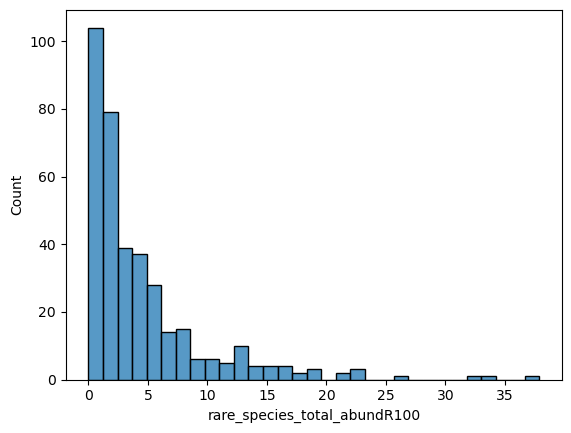

In [17]:
sns.histplot(trimmed_metadata["rare_species_total_abundR100"])

In [18]:
trimmed_metadata.loc[trimmed_metadata["rare_species_total_abundR100"] > 5]

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,plate_row,plate_col,Total Reads,Experiment Type,Sample Month,daysincestart,Date and Time,has_rare_species,lacking_core_species,rare_species_total_abundR100
filename,,,,,,,,,,,,,,,,,,,,
A2449446903_n01_LICRNA02_A01,A01,LIC157,plant,t14,1/23/24,8:00,LIC_02,LICRNA_02,758284.0,82176.0,A,1,1246970.0,Long Term,January,83,2024-01-23 08:00:00,True,False,13.5
A2449446903_n01_LICRNA02_B02,B02,LIC170,plant,t15,1/27/24,8:00,LIC_02,LICRNA_02,1839268.0,243038.0,B,2,2982080.0,Long Term,January,87,2024-01-27 08:00:00,True,False,9.0
A2449446903_n01_LICRNA02_C07,C07,LIC243,plant,t21,2/20/24,8:00,LIC_03,LICRNA_02,5931387.0,372994.0,C,7,5220104.0,Long Term,February,111,2024-02-20 08:00:00,True,False,11.5
A2449446903_n01_LICRNA02_C12,C12,LIC315,plant,t27,3/12/24,8:00,LIC_04,LICRNA_02,10581103.0,770403.0,C,12,8128106.0,Long Term,March,132,2024-03-12 08:00:00,True,False,7.0
A2449446903_n01_LICRNA02_D04,D04,LIC208,plant,t18,2/6/24,8:00,LIC_03,LICRNA_02,1027102.0,146697.0,D,4,2097859.0,Long Term,February,97,2024-02-06 08:00:00,True,False,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_F12,F12,LIC486,plant,c1_t08,2/11/24,0:00,LICCIRC_02,LICRNA_03,1281256.0,107554.0,F,12,1278970.0,Circadian Experiment 1,February,102,2024-02-11 00:00:00,True,False,12.8
B250508004_n01_LICRNA03_G01,G01,LIC331,plant,t28,3/14/24,8:00,LIC_04,LICRNA_03,7669950.0,769306.0,G,1,8957746.0,Long Term,March,134,2024-03-14 08:00:00,True,True,13.3
B250508004_n01_LICRNA03_G04,G04,LIC367,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,1477644.0,189073.0,G,4,2732871.0,Long Term,December,34,2023-12-05 08:00:00,True,False,15.1


In [16]:
rare_abund_by_sample

sampID
LIC030    33.6
LIC125    22.3
LIC603    18.5
LIC078    22.4
LIC007    25.9
          ... 
LIC626     0.5
LIC387     0.5
LIC449     0.5
LIC056     0.5
LIC055     1.0
Name: rare_species_total_abundR100, Length: 333, dtype: float64

In [ ]:
def calculate_differential_expression_btwn_2_groups(
    list_of_normal_samples: list,
    list_of_perturbed_samples: list,
    transcriptome_data: pd.DataFrame =trimmed_transcriptome,
    metadata: pd.DataFrame =trimmed_metadata,
    name_of_perturbation_column: str,
    

):
    # Subset the transcriptome data
    normal_samples = transcriptome_data.loc[list_of_normal_samples]
    perturbed_samples = transcriptome_data.loc[list_of_perturbed_samples]
    full_transcriptome = pd.concat([normal_samples, perturbed_samples])

    ##generate the metadata object
    normal_meta_data = pd.DataFrame(index=normal_samples.index)
    perturbed_meta_data = pd.DataFrame(index=perturbed_samples.index)
    normal_meta_data["condition"] = "normal"
    perturbed_meta_data["condition"] = "perturbed"

In [38]:
trimmed_metadata[["sampID", "has_rare_species", "lacking_core_species"]].sum()

sampID                  LIC157LIC169LIC193LIC217LIC229LIC241LIC253LIC2...
has_rare_species                                                      329
lacking_core_species                                                  154
dtype: object

In [39]:
trimmed_metadata[["has_rare_species", "lacking_core_species"]].sum()

has_rare_species        329
lacking_core_species    154
dtype: int64